## Clasificación de audio para sensado inteligente

En esta práctica se realiza el análisis y clasificación de señales de audio utilizando técnicas de extracción de características acústicas y modelos de
aprendizaje automático.  

El objetivo es evaluar distintos clasificadores para identificar el tipo de ambiente o evento acústico a partir de grabaciones de audio.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio
import librosa
import librosa.display

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier
)

from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. Configuración del experimento

En esta sección se definen los parámetros globales del experimento, incluyendo
las rutas de los conjuntos de datos, la frecuencia de muestreo y las clases
consideradas para la clasificación.

In [13]:
#Dataset de Audios
DATASET_TRAIN = "Audios"
DATASET_TEST = "Audios_Test"

SR = 22050
N_MFCC = 13

CLASSES = ["bano", "cocina", "sala", "oficina", "pasos", "nula"]


## 2. Carga y preprocesamiento de audio

Se define una función para cargar archivos de audio y aplicar un preprocesamiento básico.
Se utiliza preénfasis para resaltar las componentes de alta frecuencia del audio, lo cual puede mejorar la extracción de características acústicas.

In [14]:
def cargar_audio(path, sr=22050):
    y, _ = librosa.load(path, sr=sr)
    y = librosa.effects.preemphasis(y)
    return y


## 3. Extracción de características acústicas

En esta etapa se extraen características representativas de cada señal de audio. Se utilizan coeficientes MFCC, la tasa de cruces por cero (ZCR) y la energía RMS, calculando estadísticas básicas (media y desviación estándar) para cada una.


In [15]:
def extraer_features(y, sr=22050, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)

    features = np.hstack([
        np.mean(mfcc, axis=1),
        np.std(mfcc, axis=1),
        np.mean(zcr),
        np.std(zcr),
        np.mean(rms),
        np.std(rms)
    ])

    return features


## 4. Construcción del conjunto de entrenamiento

Se cargan los archivos de audio correspondientes al conjunto de entrenamiento.

Para cada archivo se extraen las características acústicas y se asigna su etiqueta de clase correspondiente.

In [16]:
X_train = []
y_train = []

for archivo in os.listdir(DATASET_TRAIN):
    if archivo.endswith(".wav"):
        etiqueta = archivo.split("_")[1]

        if etiqueta not in CLASSES:
            continue

        ruta = os.path.join(DATASET_TRAIN, archivo)
        audio = cargar_audio(ruta)
        features = extraer_features(audio)

        X_train.append(features)
        y_train.append(etiqueta)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train shape:", X_train.shape)


Train shape: (102, 30)


## 5. Construcción del conjunto de prueba (Test)

Se cargan los archivos proporcionados para evaluación final. Este conjunto no se utiliza durante el entrenamiento y permite medir la capacidad
de generalización de los modelos entrenados.

In [17]:
X_test = []
y_test = []

for archivo in os.listdir(DATASET_TEST):
    if archivo.endswith(".wav"):
        etiqueta = archivo.split("_")[1]

        if etiqueta not in CLASSES:
            continue

        ruta = os.path.join(DATASET_TEST, archivo)
        audio = cargar_audio(ruta)
        features = extraer_features(audio)

        X_test.append(features)
        y_test.append(etiqueta)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test shape:", X_test.shape)


Test shape: (18, 30)


## 6. Escalado de características

Se aplica estandarización a las características utilizando únicamente los datos de entrenamiento para ajustar el escalador. Este paso es necesario para modelos sensibles a la escala de los datos, como KNN.

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 7. Definición de modelos de clasificación

Se definen tres modelos de clasificación: Random Forest, Extra Trees y Nearest Neighbors (KNN). Estos modelos fueron seleccionados por su buen desempeño en conjuntos de datos pequeños y por su capacidad de manejar relaciones no lineales en los datos.

In [21]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
et = ExtraTreesClassifier(n_estimators=300, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5,weights="distance")


## 8. Entrenamiento de los modelos

Cada modelo se entrena utilizando el conjunto de entrenamiento. Los modelos basados en árboles se entrenan con las características originales, mientras que KNN utiliza las características escaladas.


In [18]:
rf.fit(X_train, y_train)
et.fit(X_train, y_train)
knn.fit(X_train_scaled, y_train);


## 9. Evaluación de desempeño

Se evalúa el desempeño de cada modelo utilizando el conjunto de prueba. Se reportan métricas como precisión, recall, F1-score y F1-score macro para
comparar el rendimiento entre los distintos clasificadores.

In [19]:
modelos = {
    "Random Forest": (rf, X_test),
    "Extra Trees": (et, X_test),
    "KNN": (knn, X_test_scaled)
}

for nombre, (modelo, X_eval) in modelos.items():
    y_pred = modelo.predict(X_eval)

    print("=" * 60)
    print(nombre)
    print(classification_report(y_test, y_pred))
    print("F1-score macro:", f1_score(y_test, y_pred, average="macro"))


Random Forest
              precision    recall  f1-score   support

        bano       0.00      0.00      0.00         3
      cocina       1.00      0.67      0.80         3
        nula       1.00      0.33      0.50         3
     oficina       0.33      0.67      0.44         3
       pasos       0.43      1.00      0.60         3
        sala       1.00      0.33      0.50         3

    accuracy                           0.50        18
   macro avg       0.63      0.50      0.47        18
weighted avg       0.63      0.50      0.47        18

F1-score macro: 0.4740740740740741
Extra Trees
              precision    recall  f1-score   support

        bano       0.00      0.00      0.00         3
      cocina       1.00      1.00      1.00         3
        nula       0.00      0.00      0.00         3
     oficina       0.00      0.00      0.00         3
       pasos       0.27      1.00      0.43         3
        sala       1.00      0.67      0.80         3

    accuracy    

## 10. Análisis comparativo y matrices de confusión

Al analizar las matrices de confusión se observa que Random Forest presenta un accuracy ligeramente mayor, sin embargo Extra Trees muestra un comportamiento más equilibrado entre las clases, logrando mejores resultados en aquellas que presentan mayor confusión acústica.

Aunque Random Forest acierta más predicciones en total, Extra Trees comete menos errores graves entre clases similares, lo que se refleja en un mejor desempeño general al analizar métricas como el F1-score macro. Por esta razón, Extra Trees se considera el modelo más robusto para este conjunto de datos.

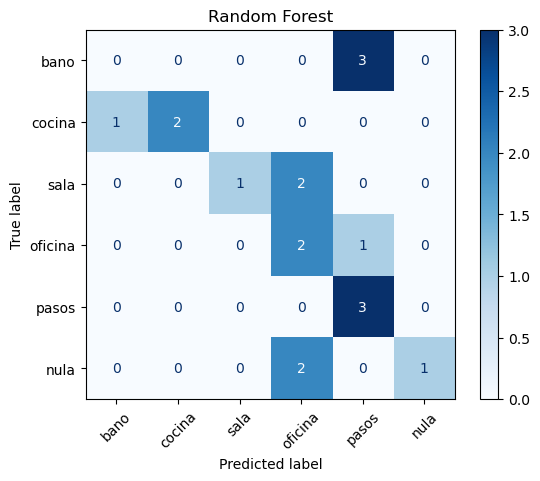

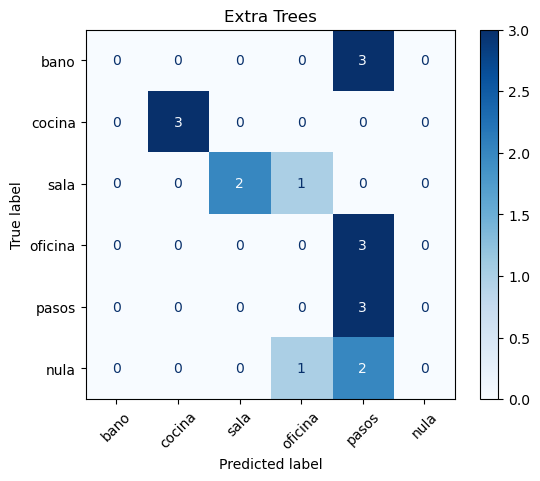

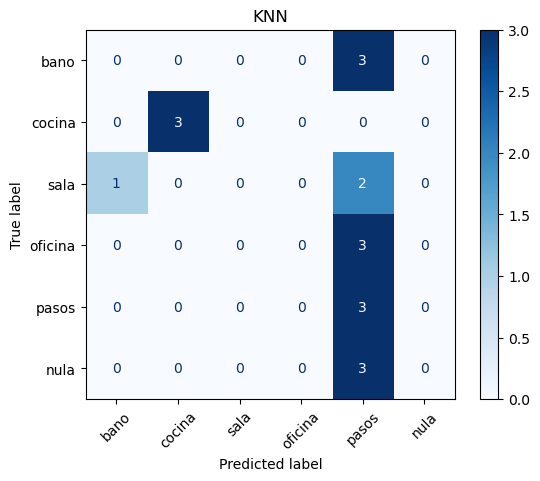

In [20]:
for nombre, (modelo, X_eval) in modelos.items():
    y_pred = modelo.predict(X_eval)

    cm = confusion_matrix(y_test, y_pred, labels=CLASSES)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=CLASSES
    )

    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(nombre)
    plt.show()


## 11. Conclusiones y observaciones

Durante el desarrollo de esta práctica se trabajó con audios reales, lo que hizo evidente que la calidad de los datos influye directamente en los resultados del modelo. Al inicio se probaron distintos modelos de clasificación, pero algunos de ellos, como SVM y MLP, no ofrecieron buenos resultados debido a la cantidad limitada de audios disponibles.

Por este motivo se decidió trabajar con Random Forest, Extra Trees y KNN, ya que estos modelos se adaptan mejor a conjuntos de datos pequeños y ruidosos. Aunque Random Forest obtuvo el accuracy más alto, Extra Trees mostró un desempeño más equilibrado entre las distintas clases, cometiendo menos errores cuando los sonidos eran similares entre sí. Por esta razón, Extra Trees fue considerado el modelo con mejor desempeño general.

Durante el análisis del conjunto de prueba, se escucharon manualmente los audios proporcionados para el Test. En este proceso se identificó que algunos audios no coincidían claramente con su etiqueta asignada. Por ejemplo, varios audios etiquetados como baño contenían sonidos de pasos,
lo que dificulta que el modelo pueda clasificarlos correctamente.

Estas inconsistencias explican parte de los errores observados en las matrices de confusión, especialmente entre las clases baño, pasos y nula, donde los sonidos pueden ser muy parecidos. En cambio, las clases con sonidos más claros y definidos fueron identificadas con mayor facilidad por los modelos.

En conclusión, esta práctica permitió comprender que en problemas de clasificación de audio no basta con elegir un buen modelo, también es fundamental que los audios estén bien etiquetados y sean consistentes. Trabajar con datos reales mostró que muchos errores no se deben al modelo, sino a la naturaleza del sonido y a la forma en que fue grabado.
